<a href="https://colab.research.google.com/github/HamidMandi/MNE/blob/main/Overview_of_MEG_EEG_analysis_with_MNE_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of MEG/EEG analysis with MNE-Python

This tutorial covers the basic EEG/MEG pipeline for event-related analysis: 
* loading data
* epoching
* averaging
* plotting
* and estimating cortical activity from sensor data. 

It introduces the core MNE-Python data structures `Raw`, `Epochs`, `Evoked`, and `SourceEstimate`, and covers a lot of ground fairly quickly (at the expense of depth). Subsequent tutorials address each of these topics in greater detail.

In [1]:
from google.colab import drive
drive.mount ("/gdrive")

Mounted at /gdrive


In [2]:
! pip install mne

     |████████████████████████████████| 6.9 MB 2.8 MB/s 


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne


# Finding and Loading Data

We’ll start this tutorial by loading one of the example datasets (called “Sample”), which contains EEG and MEG data from one subject performing an audiovisual experiment, along with structural MRI scans for that subject

The `mne.datasets.sample.data_path` function will automatically download the dataset if it isn’t found in one of the expected locations, then return the directory path to the dataset (see the documentation of data_path for a list of places it checks before downloading). 

**Note** also that for this tutorial to run smoothly on our servers, we’re using a filtered and downsampled version of the data (`sample_audvis_filt-0-40_raw.fif`), but an unfiltered version (`sample_audvis_raw.fif`) is also included in the sample dataset and could be substituted here when running the tutorial locally.

In [4]:
sample_data_folder = mne.datasets.sample.data_path()

# #sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',      #Unfiltered Data
#                                     'sample_audvis_raw.fif')

sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',         #Filtered and downsampled version of Data
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)                     #`preload=True` loads the data


Using default location ~/mne_data for sample...
Creating ~/mne_data


  0%|          | Downloading : 0.00/1.54G [00:00<?,        ?B/s]

Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


By default, `read_raw_fif` displays some information about the file it’s loading; for example, here it tells us that there are four “projection items” in the file along with the recorded data; those are 
* [SSP](https://mne.tools/stable/glossary.html#term-projector) projectors calculated to remove environmental noise from the MEG signals
* plus a projector to mean-reference the EEG channels; these are discussed in the [tutorial Background on projectors and projections](https://mne.tools/stable/auto_tutorials/preprocessing/45_projectors_background.html#tut-projectors-background).

 In addition to the information displayed during loading, you can get a glimpse of the basic details of a Raw object by printing it

In [11]:
raw

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

**Selecting Channel**

Similar to the `pick_types()` method, there is also the `pick_channels()` method to pick channels by name, and a corresponding `drop_channels()` method to remove channels by name. 

[Selecting, dropping, and reordering channels](https://mne.tools/stable/auto_tutorials/raw/10_raw_overview.html#selecting-dropping-and-reordering-channels)

In [13]:
eeg_eog = raw.copy().pick_types(meg=False, eeg=True, eog=True)
print(eeg_eog)
print(eeg_eog.info)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
<Raw | sample_audvis_filt-0-40_raw.fif, 60 x 41700 (277.7 s), ~22.0 MB, data loaded>
<Info | 14 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 60
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>


In [14]:
eeg_eog

<Raw | sample_audvis_filt-0-40_raw.fif, 60 x 41700 (277.7 s), ~22.0 MB, data loaded>

# Built-in Plotting method

`Raw` objects also have several built-in plotting methods; here we show
* the power spectral density (PSD) for each sensor type with `plot_psd`
* as well as a plot of the raw sensor traces with `plot`

In the PSD plot, we’ll only plot frequencies below 50 Hz (since our data are low-pass filtered at 40 Hz)

Effective window size : 13.639 (s)


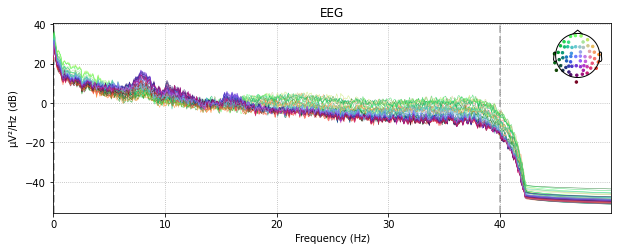

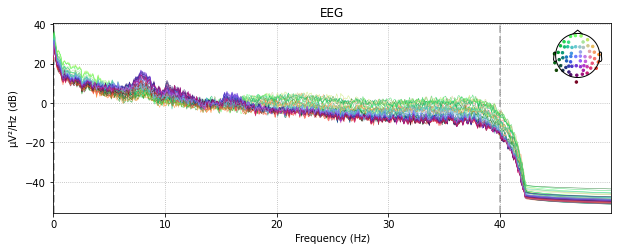

In [10]:
%matplotlib inline
eeg_eog.plot_psd(fmax=50)

In interactive Python sessions, `plot` is interactive and allows scrolling, scaling, bad channel marking, annotation, projector toggling, etc.

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


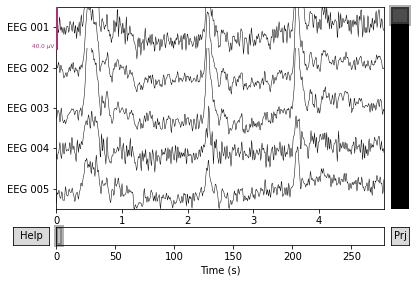

In [15]:
_ = eeg_eog.plot(duration=5, n_channels=5)

# Preprocessing

MNE-Python supports a variety of preprocessing approaches and techniques 
* maxwell filtering 
* signal-space projection
* independent components analysis
* filtering
* downsampling, etc
 see the full list of capabilities in the [mne.preprocessing](https://mne.tools/stable/preprocessing.html#module-mne.preprocessing) and [mne.filter](https://mne.tools/stable/preprocessing.html#module-mne.filter) submodules. 

Here we’ll clean up our data by performing independent components analysis [(ICA)](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA); for brevity we’ll skip the steps that helped us determined which components best capture the artifacts (see Repairing artifacts with ICA for a detailed walk-through of that process).

**Warning:**
*ICA is sensitive to low-frequency drifts and therefore requires the data to be high-pass filtered prior to fitting. Typically, a cutoff frequency of 1 Hz is recommended.*

In [16]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(eeg_eog.copy().filter(8,35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 249 samples (1.658 sec)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.8s.


<ICA | raw data decomposition, fit (fastica): 41700 samples, 20 components, channels used: "eeg">

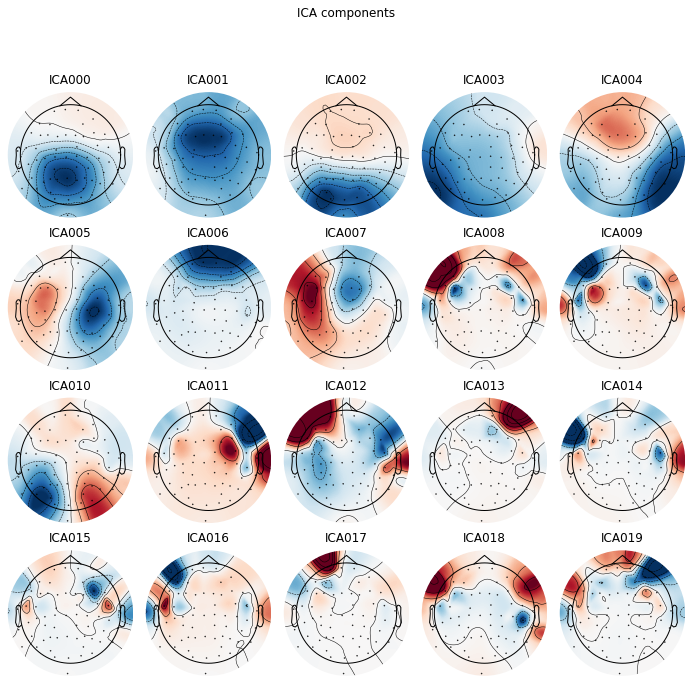

[<MNEFigure size 702x696.24 with 20 Axes>]

In [17]:
ica.plot_components(outlines="skirt")

In [23]:
ica.exclude = [7, 8, 9, 11, 12, 13, 17, 18, 19]

**befor ICA**

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


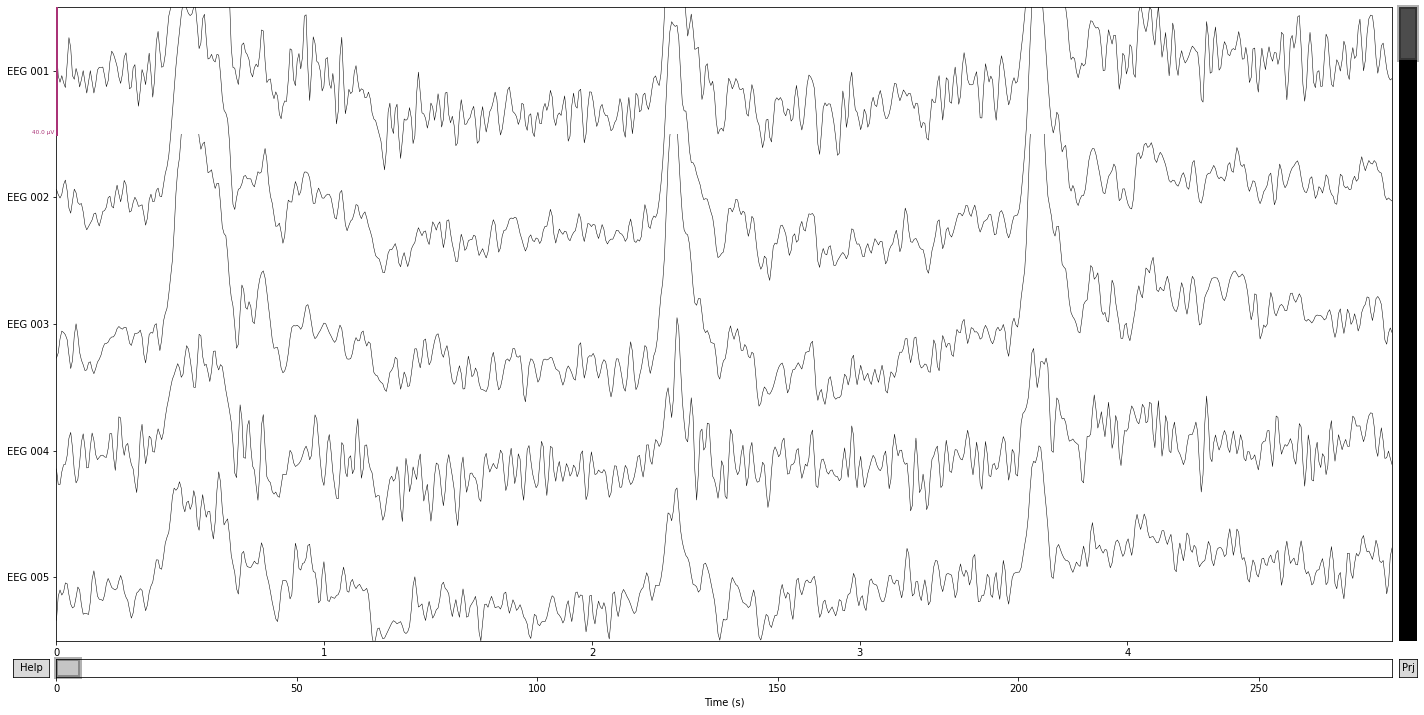

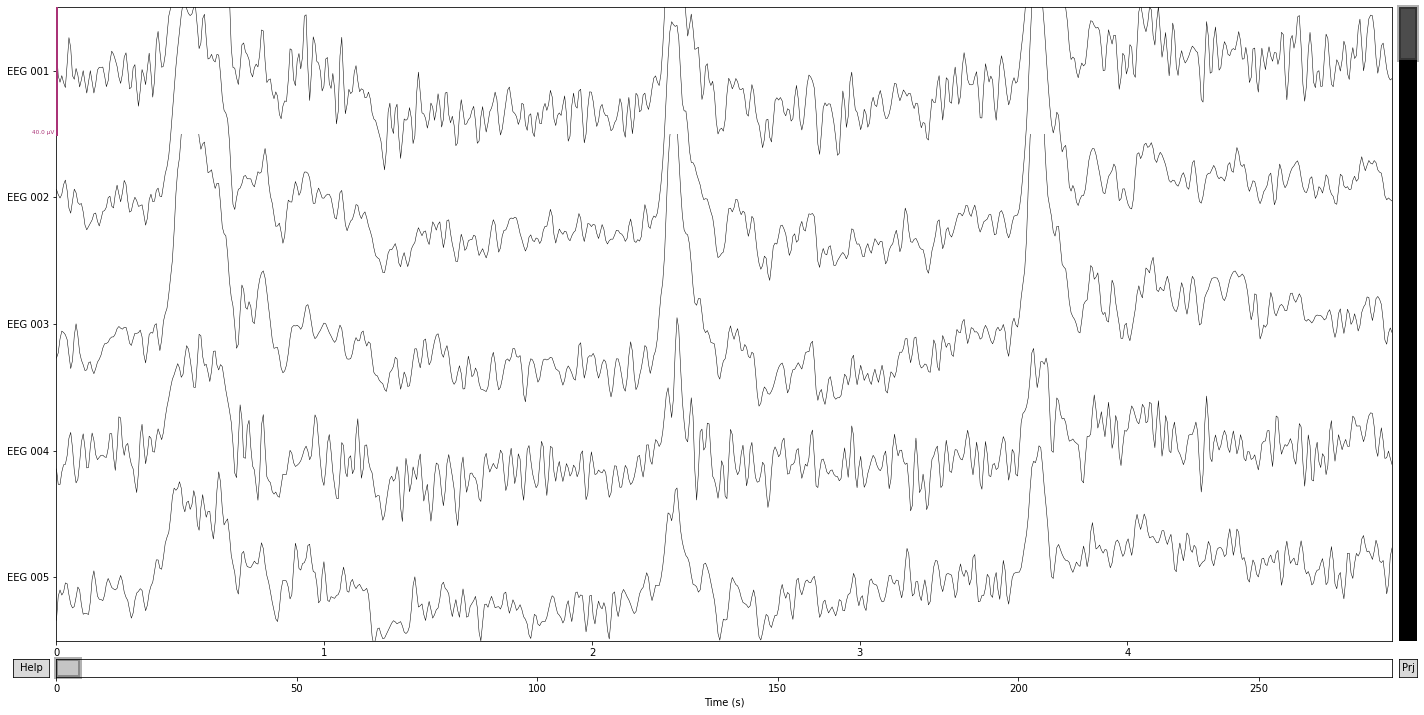

In [32]:
plt.rcParams["figure.figsize"]=20, 10
eeg_eog.plot(duration=5, start=0, n_channels=5)

**After ICA**

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 9 ICA components
    Projecting back using 59 PCA components


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


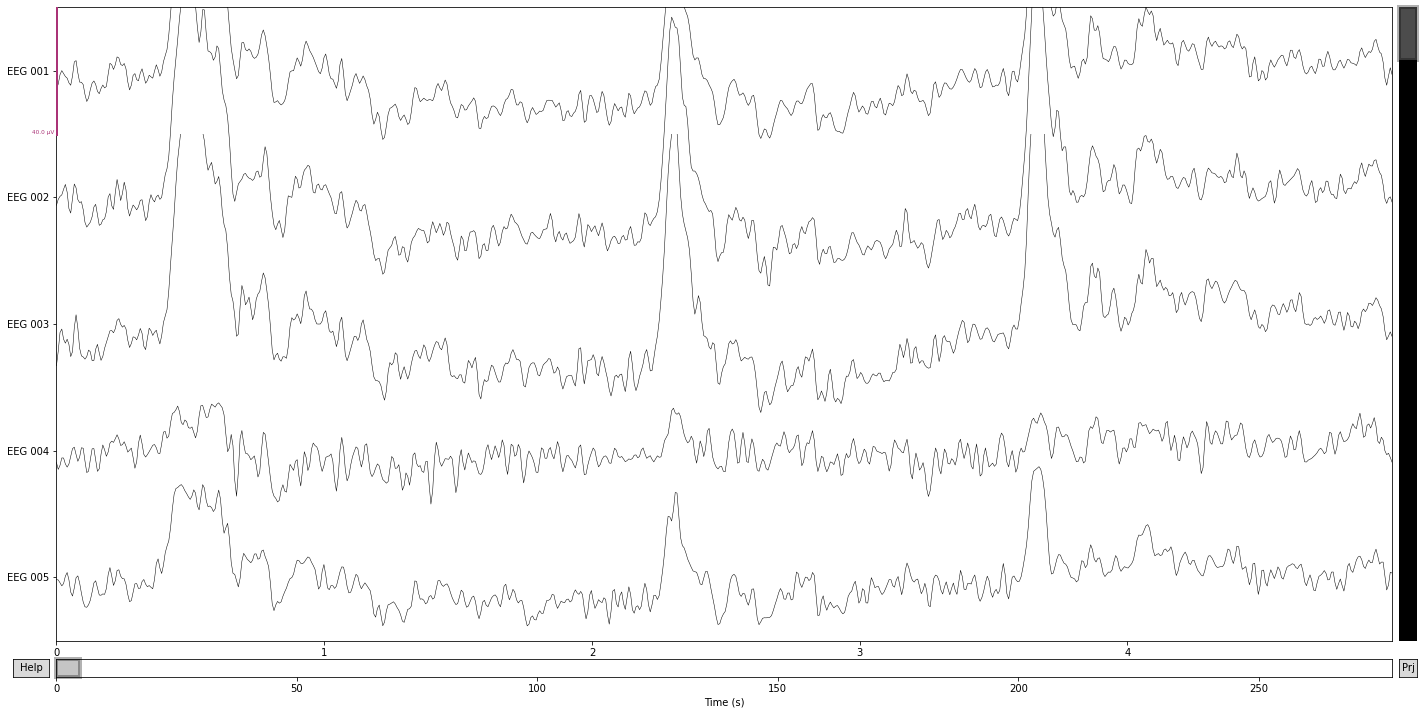

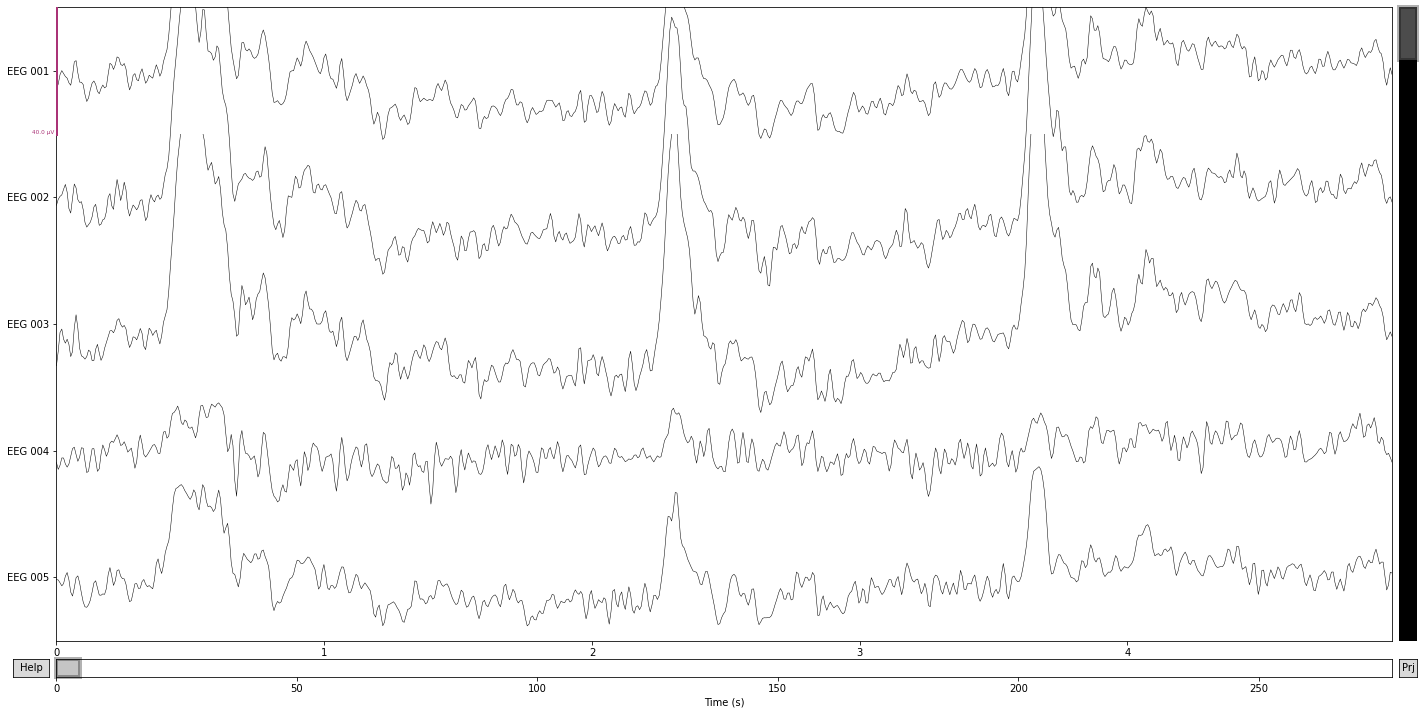

In [31]:
plt.rcParams["figure.figsize"]=20, 10
ica.apply(eeg_eog.copy(), exclude=ica.exclude).plot(duration=5, start=0, n_channels=5)   #Remove bad components (ica.exclude)

There is also a automatic method for cleaning the data

In [24]:
bad_index, sources = ica.find_bads_eog(raw, "S02", threshold=2.0)  #Remove frequeny from data (raw) that are higher than reference channel (S02) by a std of threshold (2.0)
print(bad_index)

ValueError: ignored

In [25]:
plt.rcParams["figure.figsize"]=20, 10

# Epochs

**Detecting experimental events**

Befor epoching, we need detecting eventes. Usually, these are stored in the `raw` object; In MNE, in a stim channel.


**Note** A stim channel (short for “stimulus channel”) is a channel that does **not** receive signals from an EEG, MEG, or other sensor. Instead, STIM channels record voltages (usually short, rectangular DC pulses of fixed magnitudes sent from the experiment-controlling computer) that are time-locked to experimental events, such as the onset of a stimulus or a button-press response by the subject (those pulses are sometimes called TTL pulses, event pulses, trigger signals, or just “triggers”).

Generally speaking, both the Events and Annotations data structures serve the same purpose: they provide a mapping between times during an EEG/MEG recording and a description of what happened at those times. In other words, they associate a when with a what

In [29]:
events = mne.find_events(raw)

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [33]:
print (events[0:5])

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


The resulting events array is an ordinary 3-column NumPy array, with sample number in the first column and integer event ID in the last column; the middle column is usually ignored.


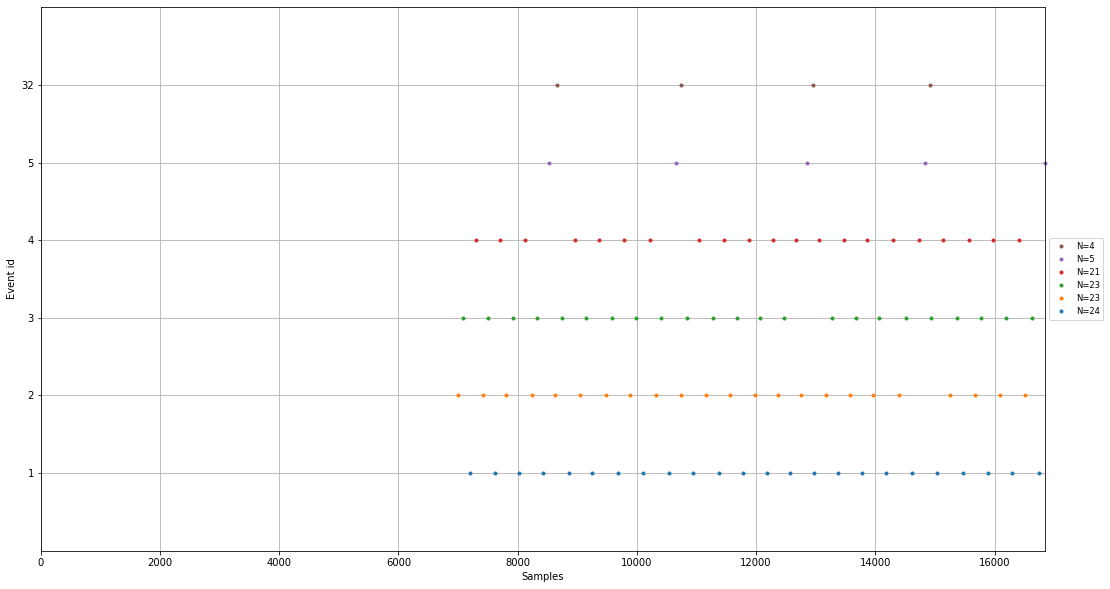

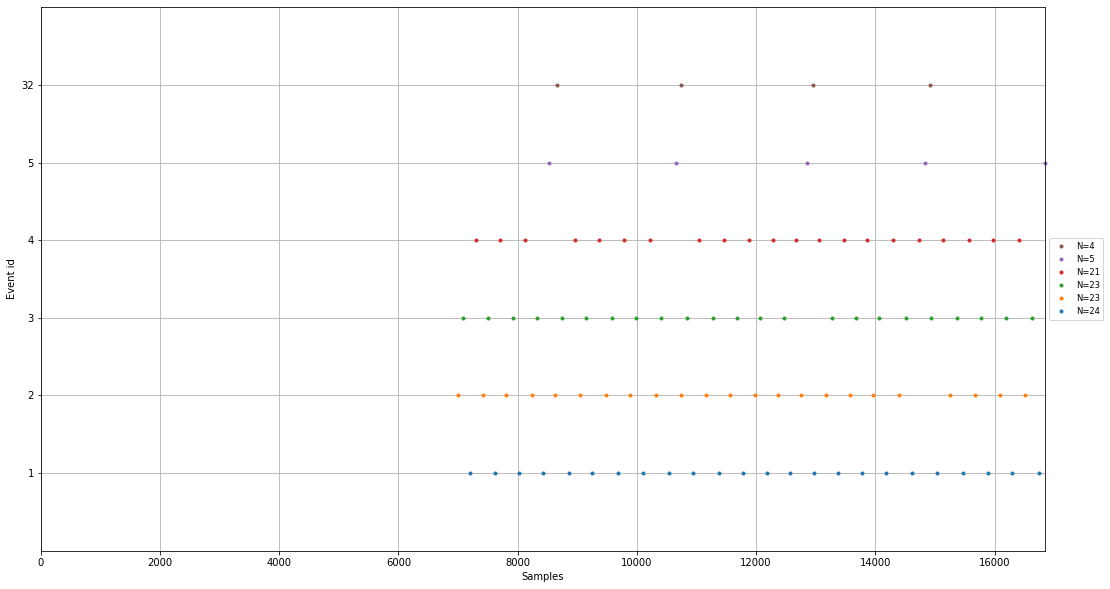

In [35]:
mne.viz.plot_events(events[:100])